In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
import matplotlib as mpl
from sklearn.linear_model import Ridge
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.cm as cm
from sklearn.model_selection import cross_val_score

import ResidualDecomposition as RD

np.random.seed(0)

In [29]:
data = pd.read_csv("Datasets/P_Dilute_Solute_Diffusion_with_features.csv").iloc[:,1:]
Y = data['Enorm (eV)']
X = data.iloc[:,4:]

data.head(5)

,Material compositions 1,Material compositions 2,Enorm (eV),E_raw (eV),Site2_MeltingT,Site1_MendeleevNumber,Site1_MiracleRadius,GSestFCClatcnt_max_value,Site2_BCCenergy_pa,Site1_BCCfermi,...,BCCenergy_pa_composition_average,MiracleRadius_min_value,MeltingT_min_value,NUnfilled_max_value,Site2_Group,Site1_CovalentRadii,Site2_NUnfilled,SpecificHeatCapacity_difference,Site1_Electronegativity,BCCenergy_pa_arithmetic_average
0,Ag,Ag,0.000000,1.824450,0.289137,0.783784,0.25,0.17956,0.799972,0.171595,...,0.844644,0.424242,0.289137,0.045455,0.666667,0.322034,0.045455,0.000000,0.603896,0.844644
1,Ag,Co,-0.090142,1.734308,0.443173,0.783784,0.25,0.17956,0.467125,0.171595,...,0.668927,0.232323,0.289137,0.136364,0.533333,0.322034,0.136364,0.072600,0.603896,0.668927
2,Ag,Cr,0.259139,2.083589,0.562225,0.783784,0.25,0.17956,0.269865,0.171595,...,0.564790,0.282828,0.289137,0.272727,0.333333,0.322034,0.272727,0.083528,0.603896,0.564790
3,Ag,Cu,-0.022200,1.802250,0.324633,0.783784,0.25,0.17956,0.727864,0.171595,...,0.806577,0.242424,0.289137,0.045455,0.666667,0.322034,0.045455,0.058548,0.603896,0.806577
4,Ag,Fe,0.317672,2.142122,0.455598,0.783784,0.25,0.17956,0.365132,0.171595,...,0.615083,0.232323,0.289137,0.181818,0.466667,0.322034,0.181818,0.083528,0.603896,0.615083


We first demonstrate a simple straightforward machine learning pipeline to predict the target labels. We scale the data, and carry out a randomized CV search to determine the optimal parameters for the RF model.

In [11]:
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
distributions = dict(n_estimators=np.arange(10, 500, 10), max_depth=np.arange(2,50))
clf = RandomizedSearchCV(rf, distributions, n_iter=100, n_jobs=-1)
clf.fit(X, Y)
rf_best = clf.best_estimator_

In [12]:
rf_best

RandomForestRegressor(max_depth=37, n_estimators=50, n_jobs=-1)

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8)
cv_score = np.mean(np.abs(cross_val_score(rf_best, X, Y, cv=5, scoring="neg_mean_squared_error")))
print("Average 5-fold CV MSE score is: {} eV".format(cv_score))

Average 5-fold CV MSE score is: 0.09634986247135421 eV


For the optimal model we plot the relative importance of each of the features in the following plot

Text(0, 0.5, 'Feature Descriptor')

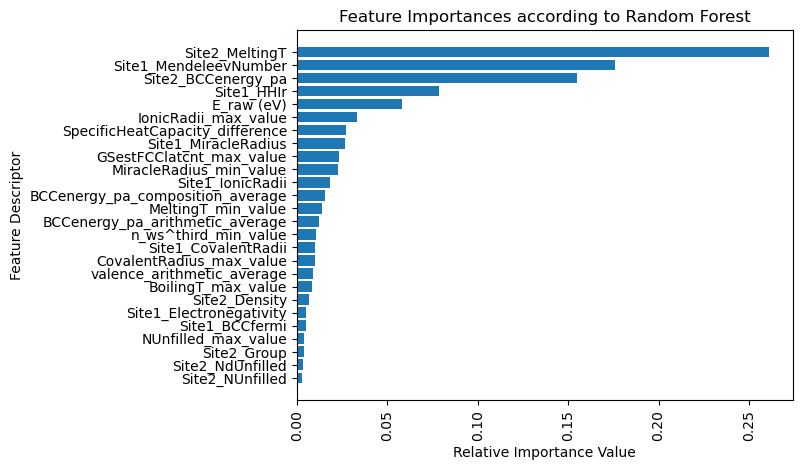

In [16]:
features_vals = np.sort(rf_best.feature_importances_)
features_args = np.argsort(rf_best.feature_importances_)

plt.xticks(rotation=90)
plt.barh(data.columns[4:][features_args], features_vals)
plt.title("Feature Importances according to Random Forest")
plt.xlabel("Relative Importance Value")
plt.ylabel("Feature Descriptor")

In [17]:
data_lr = np.genfromtxt("Data/LR_DSD_norm.csv", delimiter=',')
data_lr_composition = data_lr
summed_composition = np.sum(data_lr_composition, axis=0)
data_lr_contribution = ((data_lr_composition.T * -np.sign(summed_composition))).T

data_rf = np.genfromtxt("Data/RF_DSD_norm.csv", delimiter=',')
data_rf_composition = data_rf
summed_composition = np.sum(data_rf_composition, axis=0)
data_rf_contribution = ((data_rf_composition.T * -np.sign(summed_composition))).T

We plot the CC plots for the models LR and RF for the Dilute Solute Diffusion dataset below, it can be seen that the Random Forest model produces a more uniform CC-plot and should be a better choice of model than the LR model. 

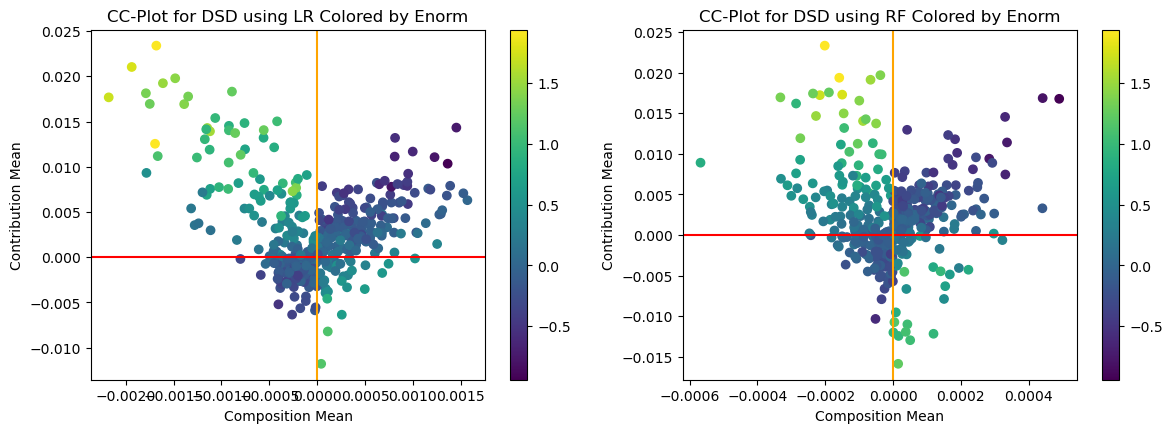

In [18]:
plt.figure(figsize=(14,10))

plt.subplot(221)

plt.title("CC-Plot for DSD using LR Colored by Enorm")
plt.xlabel("Composition Mean")
plt.ylabel("Contribution Mean")
plt.axhline(0, c='r')
plt.axvline(0, c='orange')
plt.scatter(np.mean(data_lr_composition, axis=0), np.mean(data_lr_contribution, axis=1), c=Y)
cbar = plt.colorbar()
cbar.ax.tick_params()

plt.subplot(222)

plt.title("CC-Plot for DSD using RF Colored by Enorm")
plt.xlabel("Composition Mean")
plt.ylabel("Contribution Mean")
plt.axhline(0, c='r')
plt.axvline(0, c='orange')
plt.scatter(np.mean(data_rf_composition, axis=0), np.mean(data_rf_contribution, axis=1), c=Y)

cbar = plt.colorbar()
cbar.ax.tick_params()

We detect and plot noteworthy outliers in the CC properties of the DSD data by means of outlier and clustering analysis

In [19]:
iforest = IsolationForest(n_estimators=100, n_jobs=-1)
iforest_outliers_rf = iforest.fit_predict(data_rf_composition)

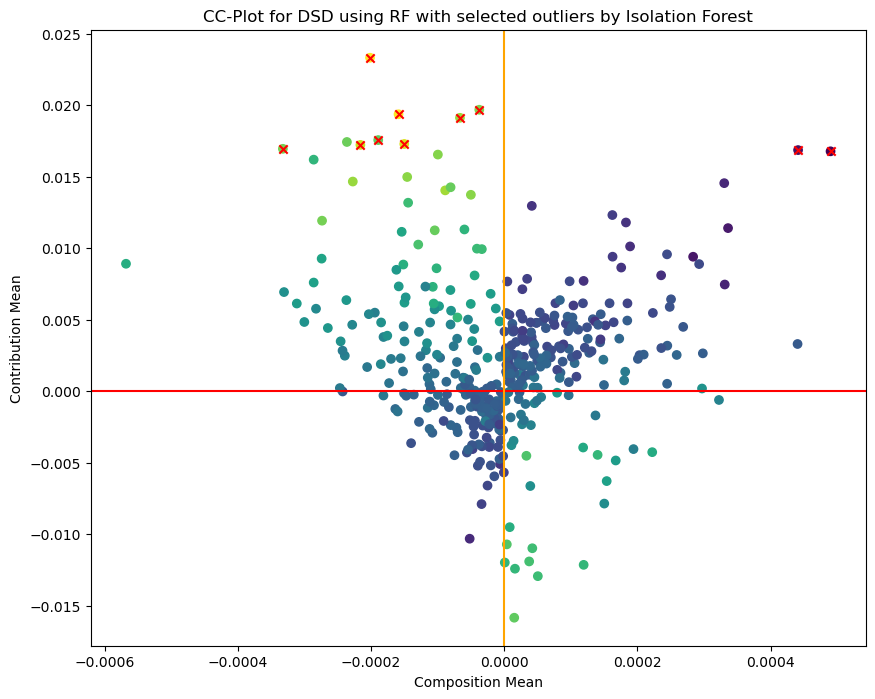

In [20]:
plt.figure(figsize=(10,8))

plt.title("CC-Plot for DSD using RF with selected outliers by Isolation Forest")
plt.xlabel("Composition Mean")
plt.ylabel("Contribution Mean")
plt.axhline(0, c='r')
plt.axvline(0, c='orange')
rf_outliers = np.argwhere(iforest_outliers_rf==-1).flatten()
plt.scatter(np.mean(data_rf_composition, axis=0), np.mean(data_rf_contribution, axis=1), c=Y)
plt.scatter(np.mean(data_rf_composition, axis=0)[rf_outliers], \
            np.mean(data_rf_contribution, axis=1)[rf_outliers], c='r', marker='x')

In [30]:
contribution_sorting_args = np.argsort(np.abs(np.mean(data_rf_contribution, axis=1)[rf_outliers]))
contribution_sorting_vals = np.sort(np.abs(np.mean(data_rf_contribution, axis=1)[rf_outliers]))

In [31]:
data.iloc[rf_outliers].iloc[contribution_sorting_args]

,Material compositions 1,Material compositions 2,Enorm (eV),E_raw (eV),Site2_MeltingT,Site1_MendeleevNumber,Site1_MiracleRadius,GSestFCClatcnt_max_value,Site2_BCCenergy_pa,Site1_BCCfermi,...,BCCenergy_pa_composition_average,MiracleRadius_min_value,MeltingT_min_value,NUnfilled_max_value,Site2_Group,Site1_CovalentRadii,Site2_NUnfilled,SpecificHeatCapacity_difference,Site1_Electronegativity,BCCenergy_pa_arithmetic_average
311,Pd,La,-0.93933,1.706683,0.277021,0.743243,0.223684,0.574777,0.637781,0.339765,...,0.661222,0.404040,0.277021,0.409091,0.133333,0.220339,0.409091,0.021077,0.779221,0.661222
279,Ni,S,-0.79502,2.157819,0.044511,0.729730,0.013158,0.387788,0.777876,0.326243,...,0.720822,0.010101,0.044511,0.090909,1.000000,0.000000,0.090909,0.103825,0.590909,0.720822
57,Al,V,1.34120,2.607301,0.563092,0.891892,0.210526,0.183424,0.314052,0.721863,...,0.549748,0.323232,0.202027,0.318182,0.266667,0.050847,0.318182,0.160422,0.396104,0.549748
53,Al,Tc,1.70830,2.974401,0.634465,0.891892,0.210526,0.183424,0.224005,0.721863,...,0.502211,0.343434,0.202027,0.227273,0.400000,0.050847,0.227273,0.257611,0.396104,0.502211
33,Al,Mo,1.76010,3.026201,0.769121,0.891892,0.210526,0.183424,0.165067,0.721863,...,0.471096,0.373737,0.202027,0.272727,0.333333,0.050847,0.272727,0.253708,0.396104,0.471096
212,Mg,Tc,1.24556,2.657998,0.634465,0.824324,0.460526,0.330382,0.224005,0.176591,...,0.590336,0.343434,0.199001,0.227273,0.400000,0.355932,0.227273,0.304450,0.201299,0.590336
52,Al,Ta,1.51590,2.782001,0.882971,0.891892,0.210526,0.224218,0.086523,0.721863,...,0.429631,0.393939,0.202027,0.318182,0.266667,0.050847,0.318182,0.296643,0.396104,0.429631
43,Al,Re,1.92290,3.189001,0.931805,0.891892,0.210526,0.183424,0.066960,0.721863,...,0.419304,0.353535,0.202027,0.227273,0.400000,0.050847,0.227273,0.297814,0.396104,0.419304
202,Mg,Re,1.38375,2.796188,0.931805,0.824324,0.460526,0.330382,0.066960,0.176591,...,0.507429,0.353535,0.199001,0.227273,0.400000,0.355932,0.227273,0.344653,0.201299,0.507429
58,Al,W,1.93620,3.202301,1.000000,0.891892,0.210526,0.183424,0.000000,0.721863,...,0.383954,0.333333,0.202027,0.272727,0.333333,0.050847,0.272727,0.300546,0.396104,0.383954


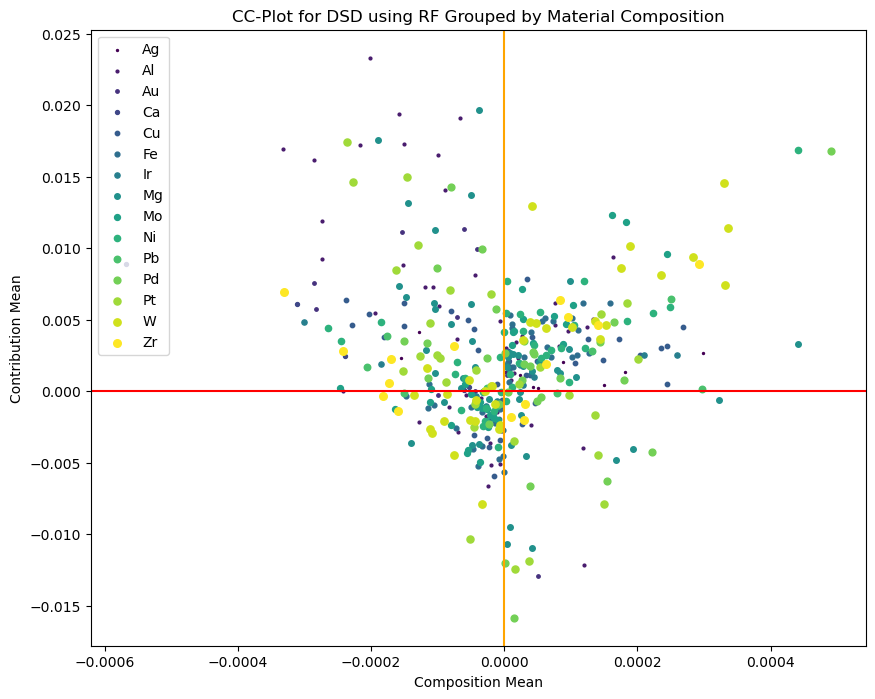

In [33]:
plt.figure(figsize=(10,8))

elements, counts = np.unique(data.iloc[:,0], return_counts=True)
sorted_counts = np.argsort(counts)

plt.title("CC-Plot for DSD using RF Grouped by Material Composition")
plt.xlabel("Composition Mean")
plt.ylabel("Contribution Mean")
plt.axhline(0, c='r')
plt.axvline(0, c='orange')

cmap = cm.get_cmap('viridis', len(elements))

color_count = 0
for e in elements:
    indices = np.where(data['Material compositions 1'] == e)    
    plt.scatter(np.mean(data_rf_composition, axis=0)[indices], np.mean(data_rf_contribution, axis=1)[indices]\
                ,color=cmap.colors[color_count], label=e, s=2 + color_count * 2)
    
    color_count+=1
    
plt.legend()

<BarContainer object of 15 artists>

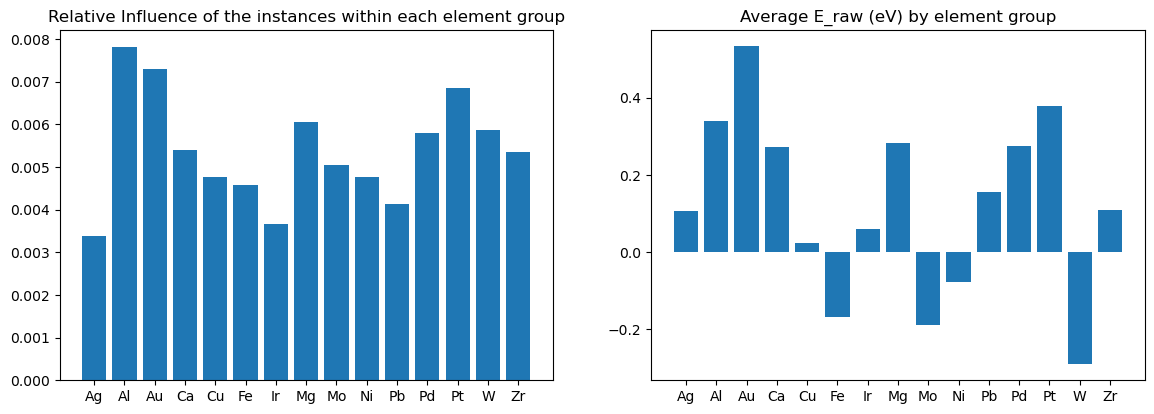

In [34]:
elements, counts = np.unique(data.iloc[:,0], return_counts=True)
sorted_counts = np.argsort(counts)

plt.figure(figsize=(14,10))

plt.subplot(221)

influence_vals = []

for e in elements:
    indices = np.where(data['Material compositions 1'] == e)
    influence_vals.append(np.mean(np.mean(np.abs(data_rf_contribution)[indices], axis=0)))
    
plt.title("Relative Influence of the instances within each element group")
plt.bar(elements, influence_vals)

plt.subplot(222)

influence_vals = []

for e in elements:
    indices = np.where(data['Material compositions 1'] == e)[0]
    influence_vals.append(np.mean(data['Enorm (eV)'][indices]))
    
plt.title("Average E_raw (eV) by element group")
plt.bar(elements, influence_vals)

Let us also consider the diversity of samples from within each Material Composition element group. We define diversity as the average distance from the element center of each group of elements, we see that there is no significant difference in the diversity of data from within the most influential groups in the analysis.

InvalidIndexError: (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),)

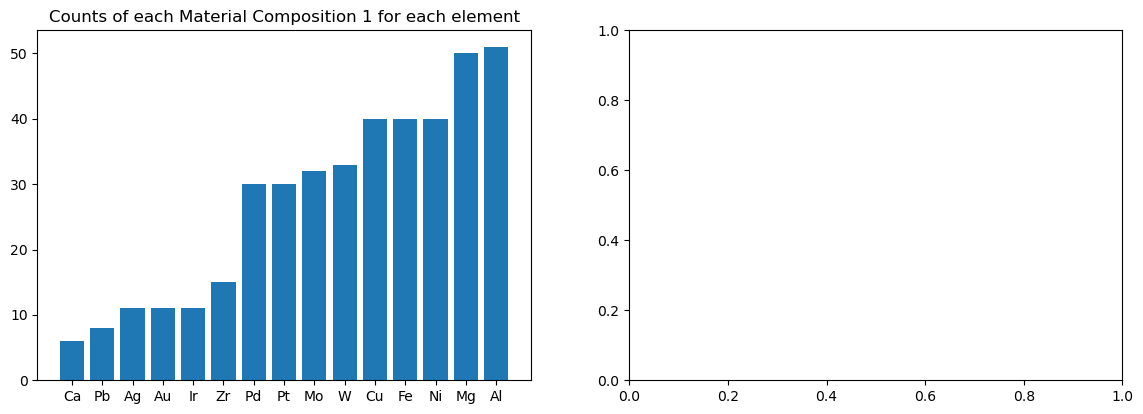

In [35]:
elements, counts = np.unique(data.iloc[:,0], return_counts=True)
sorted_counts = np.argsort(counts)

plt.figure(figsize=(14,10))

plt.subplot(221)
plt.title("Counts of each Material Composition 1 for each element")
plt.bar(elements[sorted_counts], counts[sorted_counts])

plt.subplot(222)
prototypes = []
diversity = []

for e in elements:
    indices = np.where(data['Material compositions 1'] == e)
    prot = np.mean(X[indices], axis=0)
    prototypes.append(prot)
    div = np.mean((X[indices] - prot) ** 2)
    diversity.append(div)
    
plt.title("Diversity of samples within each element Group")
plt.bar(elements, diversity)